In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

### Correlator generalized for L sites

In [4]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hz

In [5]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [6]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)
psi_0 = psi.copy()

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

psil = np.array([Sx_list[l] @ psi_0 for l in range(L)])


# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X_ell e^-iHt X_L/2 |psi>
Cs = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.266407934929784
Excited state energy: -19.52953059144965


In [7]:
print(Cs.shape) 
#form is (L,2**n) <-> (X,T)

(11, 1024)


Text(0.5, 1.0, 'correlation function evaluated on 11 sites')

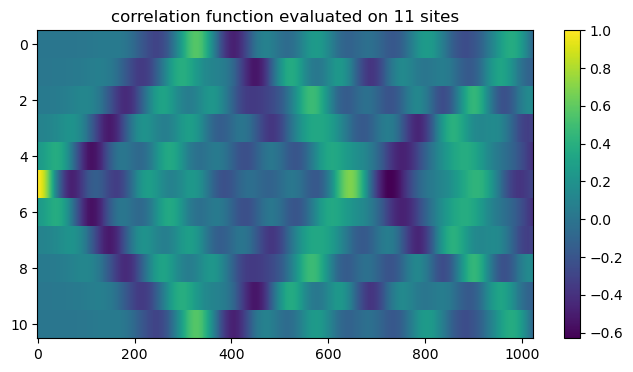

In [8]:
plt.figure(figsize=(8, 4))
plt.imshow(Cs.real, aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()
plt.title("correlation function evaluated on " + f"{L}" + " sites")

In [9]:
import importlib

import sys
sys.path.append('/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/Chebyshev')
sys.path.append('/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI')
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/Chebyshev")
sys.path.append("/home/t30/all/go56vod/Desktop/Student-Research-Job/TCI")



import Chebyshev as Cbs
import TCI_Lsite as TCI

importlib.reload(Cbs)
importlib.reload(TCI)

<module 'TCI_Lsite' from '/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job/TCI/TCI_Lsite.py'>

### Interpolation with TCI

In [10]:
D = L

func_vals = Cs.T #Cs is in the form (X,T)

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: Cs.reshape((D,) + (2,) * n)[:,*t]
#here we have to define func as the initialization of the class
func = TCI.function(f_t)

As, _, eval, err_2, err_max, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=10, # bond dimension
                                   iters=1)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

err_max:  0.00013495195083311717
err_2:  7.6082458110444e-05
eval/D:  652

repeated evaluations:  1208
unique evaluations 652
unique + repeated:  1860
total evaluations:  1860

34.49158952688781 0.9999999999999982


/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


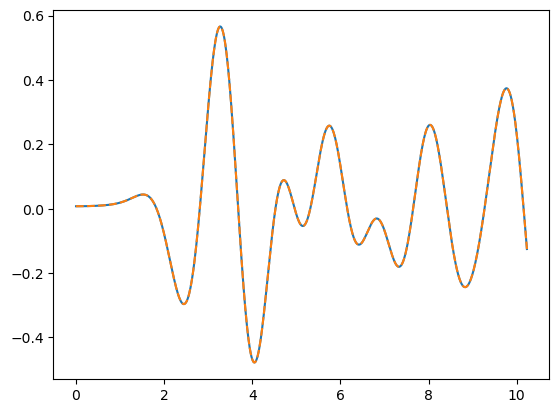

In [11]:
ts = np.arange(N)*dt

plt.plot(ts, func_vals[:,0])
plt.plot(ts, func_interp[:,0], '--')

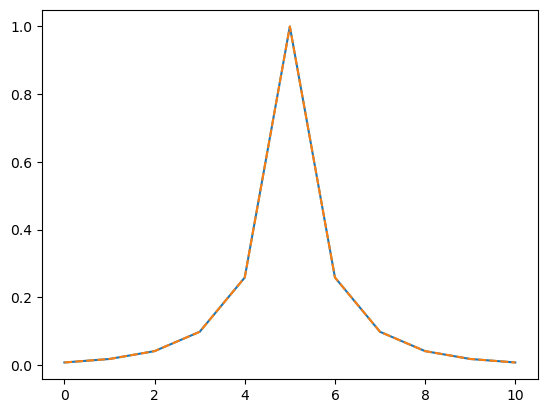

In [12]:
xs = np.arange(L)
plt.plot(xs, func_vals[0,:], "-")
plt.plot(xs, func_interp[0,:], "--")

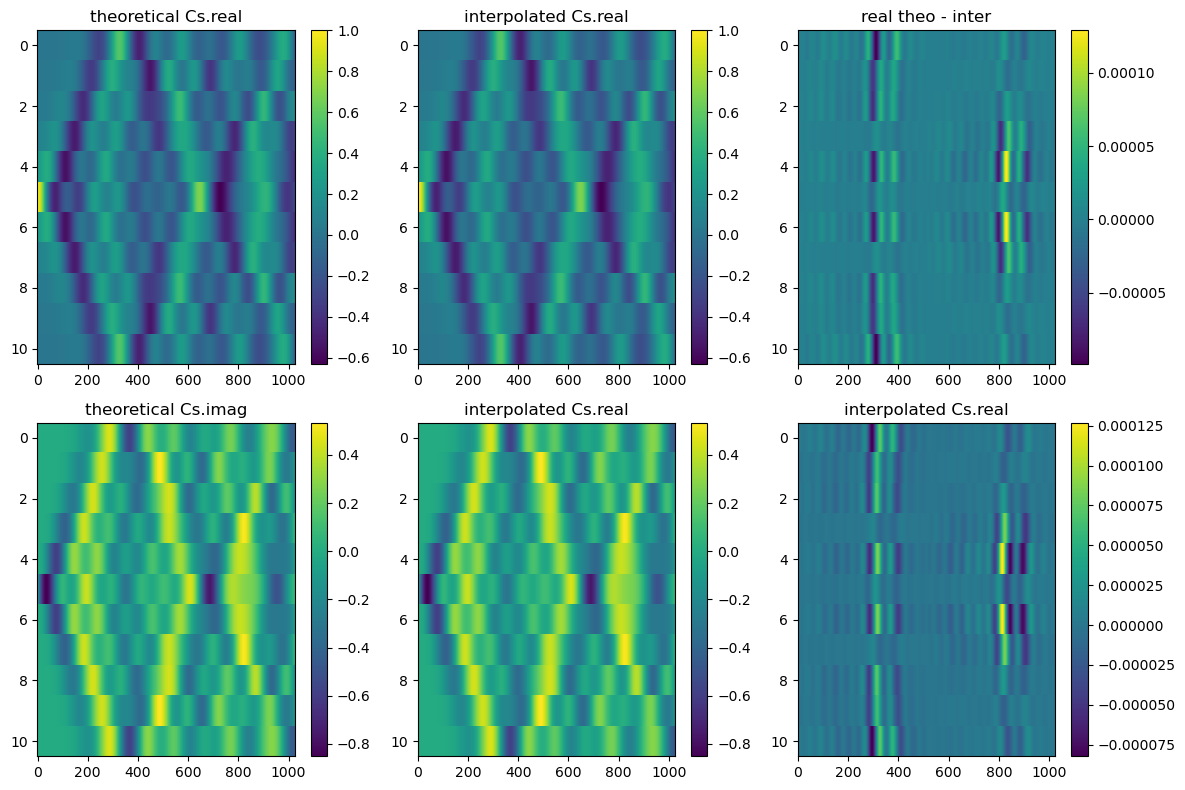

In [13]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

im = axs[0,0].imshow(Cs.real, aspect = 'auto', interpolation = 'none')
cbar = fig.colorbar(im, ax = axs[0,0], 
                    #fraction=0.046, pad=0.04
                    )
#cbar.ax.tick_params(labelsize=8)
axs[0,0].set_title('theoretical Cs.real')

im = axs[0,1].imshow(np.real(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[0,1])
axs[0,1].set_title('interpolated Cs.real')

im =axs[0,2].imshow(Cs.real-np.real(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[0,2])
axs[0,2].set_title('real theo - inter')

im = axs[1,0].imshow(Cs.imag, aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,0])
axs[1,0].set_title('theoretical Cs.imag')

im = axs[1,1].imshow(np.imag(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,1])
axs[1,1].set_title('interpolated Cs.real')

im = axs[1,2].imshow(Cs.imag-np.imag(interp_Cs), aspect = 'auto', interpolation = 'none')
fig.colorbar(im, ax = axs[1,2])
axs[1,2].set_title('interpolated Cs.real')

plt.tight_layout()
plt.show()


### Colormap of theoretical Cs vs interpolated Cs

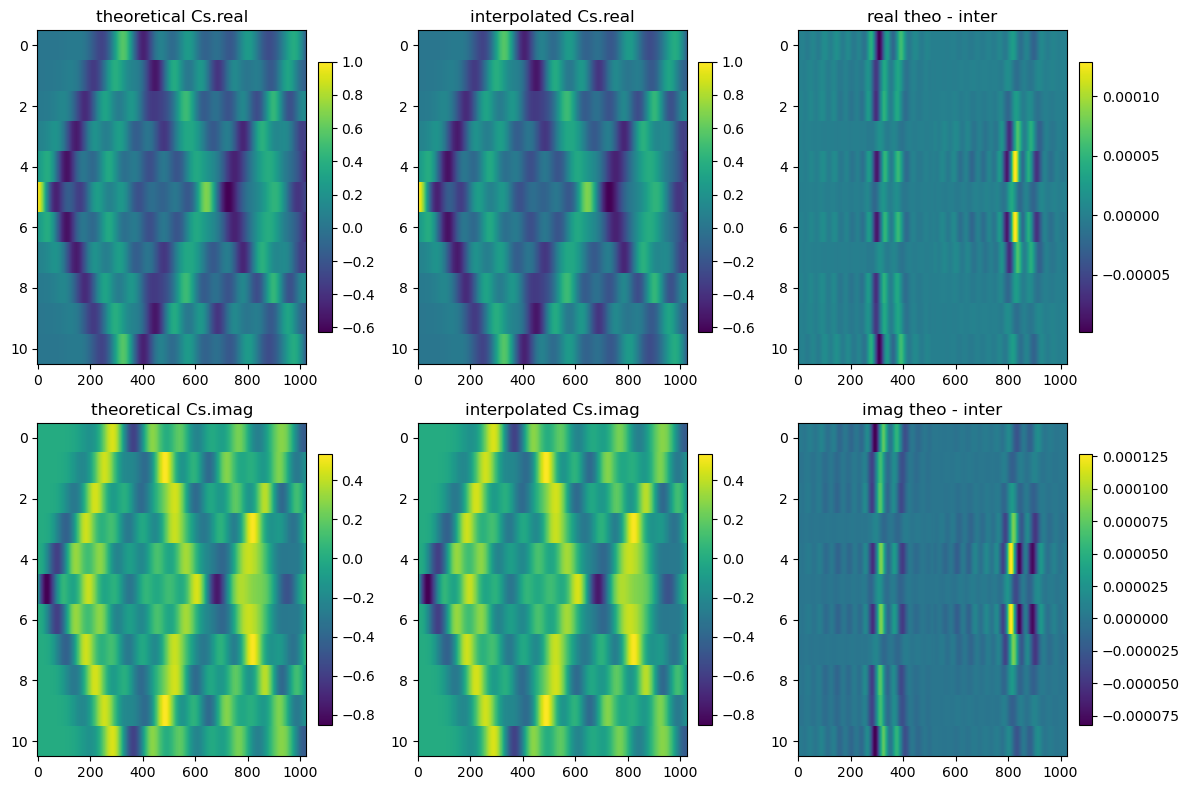

In [14]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

# Data and titles for each subplot
data = [
    (Cs.real, 'theoretical Cs.real'),
    (np.real(interp_Cs), 'interpolated Cs.real'),
    (Cs.real - np.real(interp_Cs), 'real theo - inter'),
    (Cs.imag, 'theoretical Cs.imag'),
    (np.imag(interp_Cs), 'interpolated Cs.imag'),
    (Cs.imag - np.imag(interp_Cs), 'imag theo - inter')
]

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through data and subplots
for ax, (image, title) in zip(axs.flat, data):
    im = ax.imshow(image, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar
    ax.set_title(title)

plt.tight_layout()
plt.show()

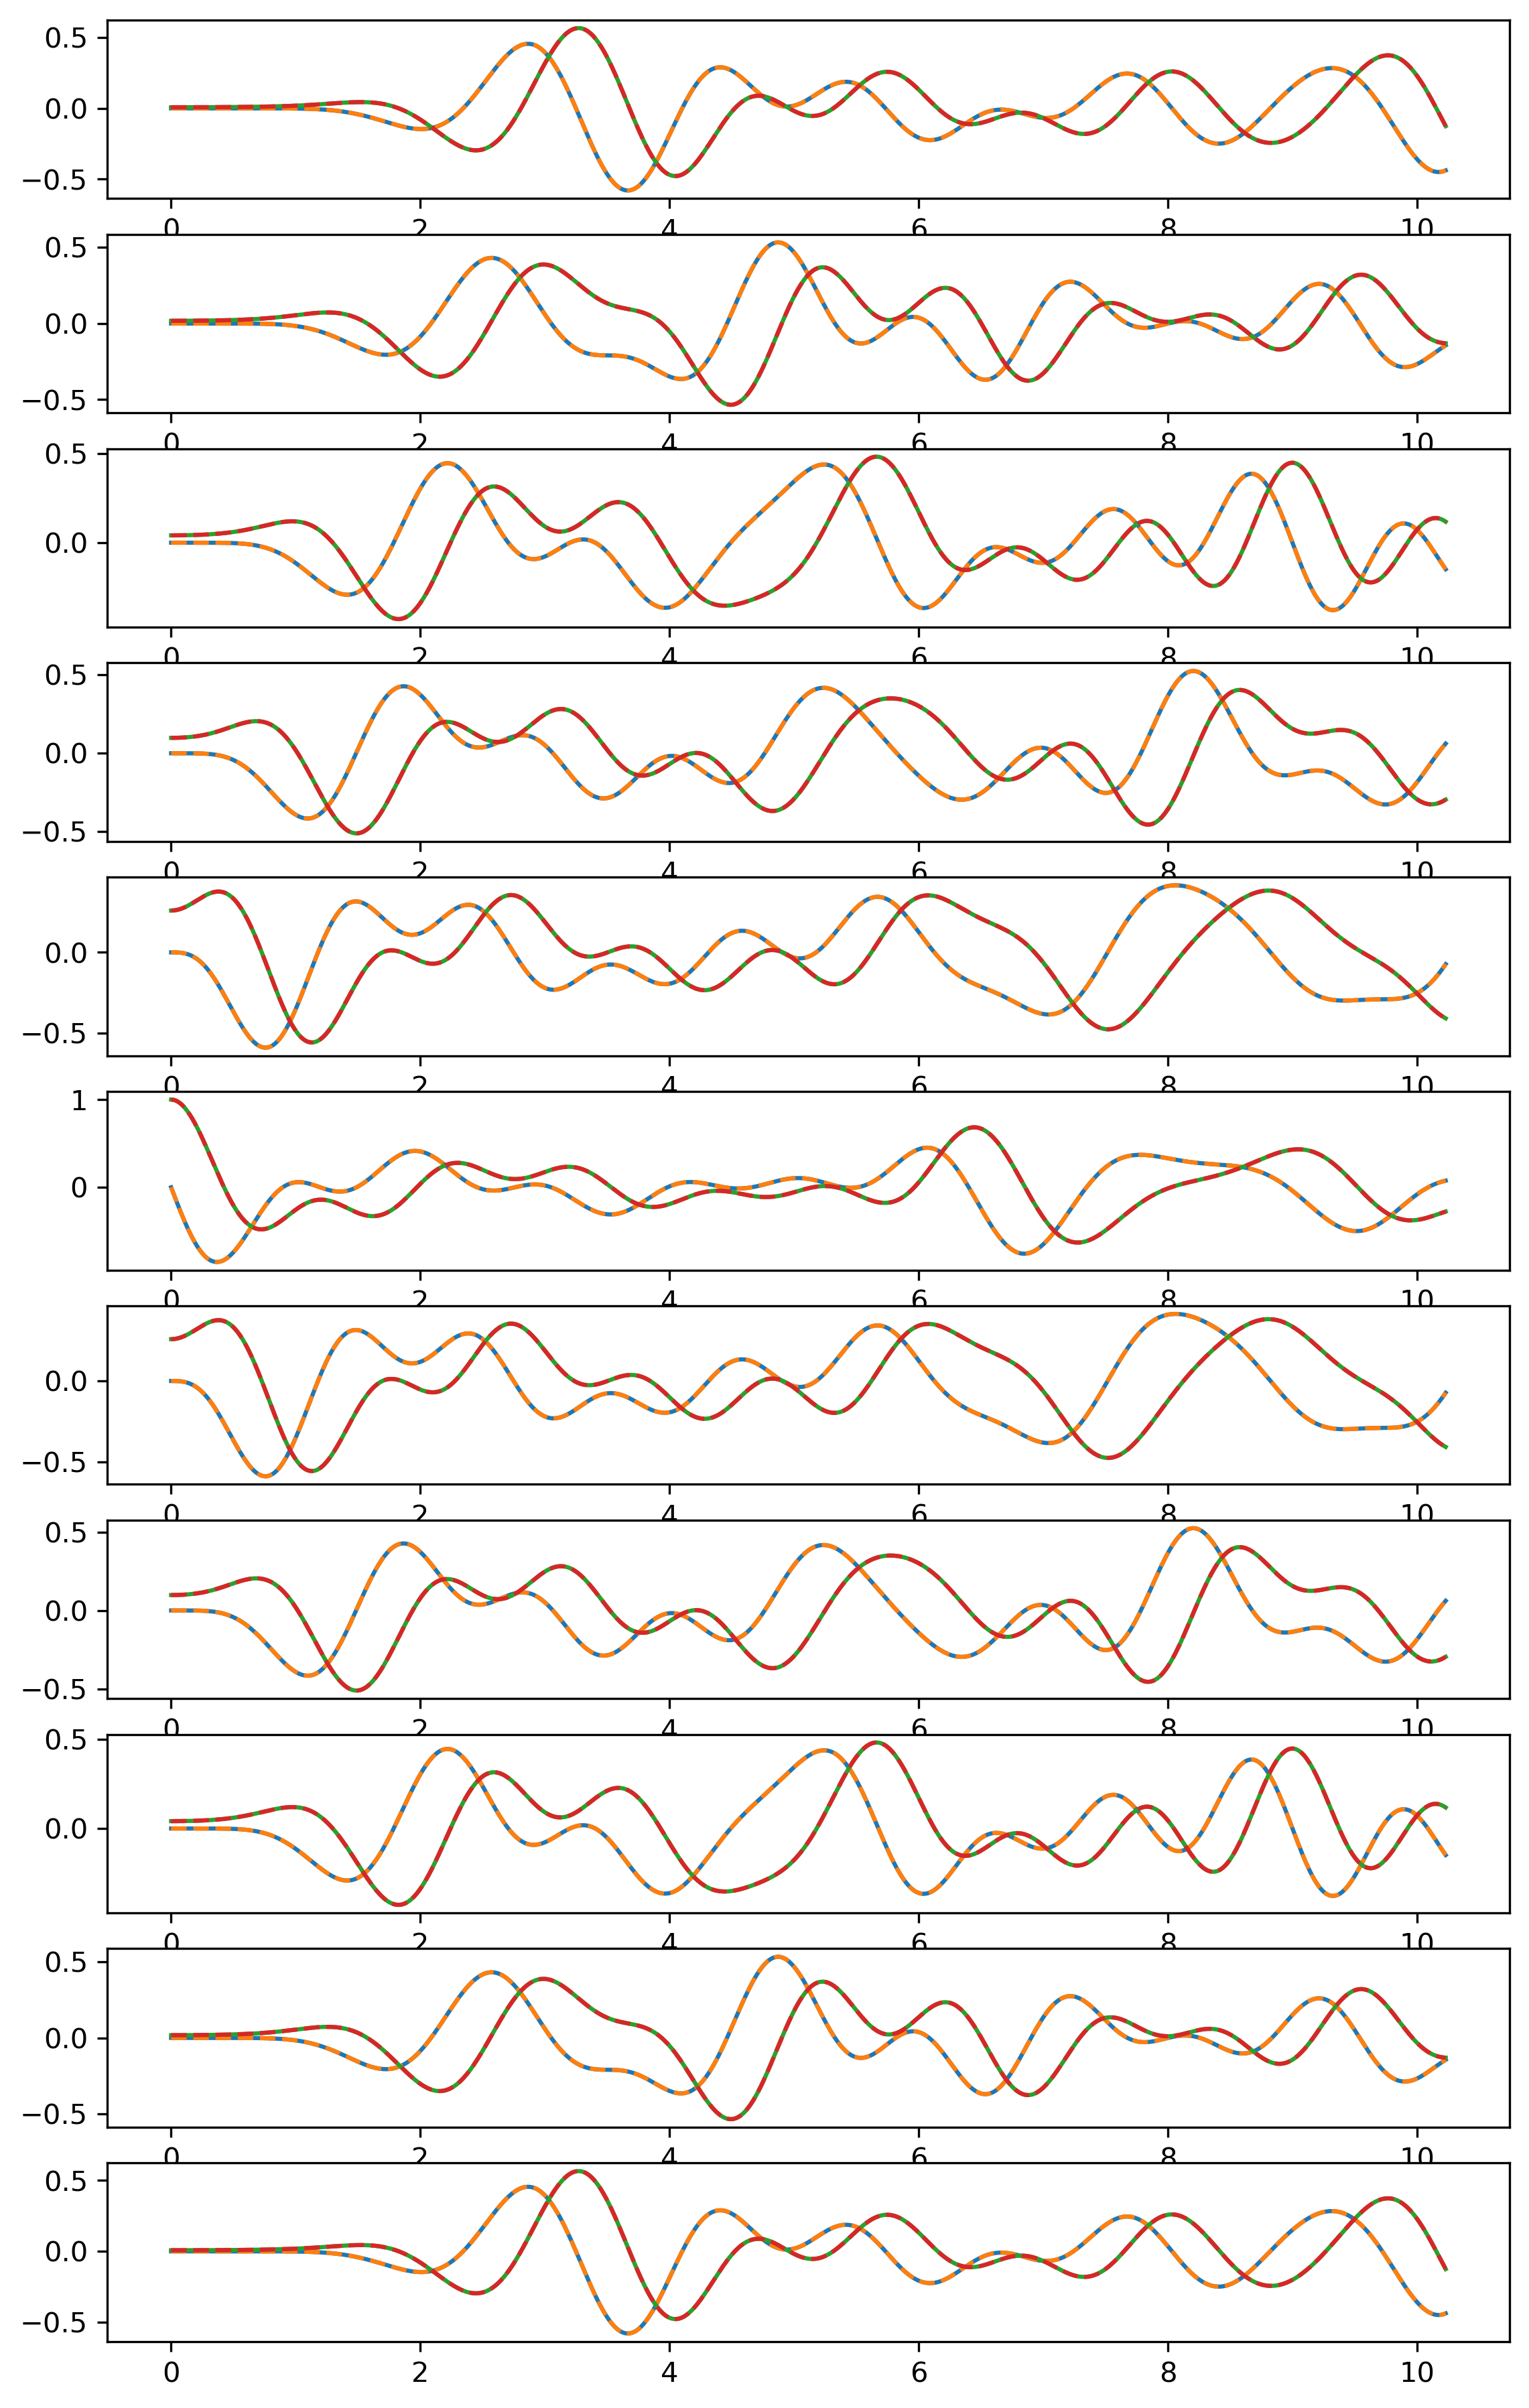

In [15]:
D_list = np.arange(D)

fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)



for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')

plt.show()

### Errors vs evaluation for TCI

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_6439/910960079.py:40: SyntaxWarning: invalid escape sequence '\c'
  plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation


err_max:  0.7313119892988896
err_2:  0.7839213909675156
eval/D:  705

repeated evaluations:  1795
unique evaluations 705
unique + repeated:  2500
total evaluations:  2500

err_max:  0.9302087648295748
err_2:  0.6713008208667317
eval/D:  739

repeated evaluations:  2725
unique evaluations 739
unique + repeated:  3464
total evaluations:  3464



err_max:  0.5784366300685546
err_2:  0.5442189647619636
eval/D:  777

repeated evaluations:  4547
unique evaluations 777
unique + repeated:  5324
total evaluations:  5324

err_max:  0.3649495989127346
err_2:  0.3378641022484808
eval/D:  871

repeated evaluations:  7489
unique evaluations 871
unique + repeated:  8360
total evaluations:  8360

err_max:  0.11642875498402698
err_2:  0.05215135141643776
eval/D:  936

repeated evaluations:  11632
unique evaluations 936
unique + repeated:  12568
total evaluations:  12568

err_max:  0.0020762209199895955
err_2:  0.0009639342505826445
eval/D:  994

repeated evaluations:  17122
unique evaluations 994
unique + repeated:  18116
total evaluations:  18116

err_max:  0.0007065801092420092
err_2:  0.00043827353656862486
eval/D:  1012

repeated evaluations:  24160
unique evaluations 1012
unique + repeated:  25172
total evaluations:  25172

err_max:  0.00024058819573506061
err_2:  0.0002072741354411254
eval/D:  1024

repeated evaluations:  32880
unique 

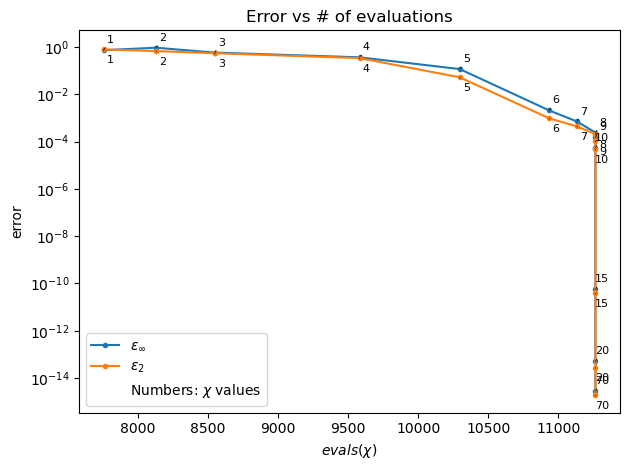

In [16]:
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(1,10)]
chi_list.extend([i for i in range(10,25,5)])
chi_list.append(70)


for chi in chi_list:
    _, _, eval, err2, errmax, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=chi, # bond dimension
                                   iters=4)       # number of back-and-forth sweeps
    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)

plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    
plt.plot([], [], ' ', label="Numbers: $\chi$ values")  # Dummy plot for chi explanation

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

### Interpolation with Chebyshev

In [17]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n
D = 11


# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
def Cs_chebyshev_Dsites(D_list, t_matrix):

    D = len(D_list)

    # get ground state
    E, psi = eigsh(H, k=1, which='SA')
    E0, psi = np.squeeze(E), np.squeeze(psi)
    psi_0 = psi.copy()

    # put in excitation
    psi = Sx_list[D//2] @ psi
    E1 = np.dot(psi.conj(), H @ psi).real

    psil = np.array([Sx_list[l] @ psi_0 for l in range(D)])

    a,b = t_matrix.shape

    print(a, b)

    t = t_matrix.reshape(-1)*N*dt
    psis = np.zeros((a*b,psi.shape[0]), dtype=np.complex128)
    for i,tt in enumerate(t):
        psis[i,:] = expm_multiply(-1j * H * tt, psi)
    corr = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * t)
    corr = corr.reshape(D, a, b)
    return corr


# exact function values
#xs = np.linspace(0, N*dt, 2**n, endpoint=False)
ts = np.arange(N)*dt

func_vals = Cs.T

# get MPS from Chebyshev interpolation
chi = 20
As, evals, err_max, err_2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension



2 20


In [18]:
print(err_2)
print(err_max)

0.00614362845713321
0.005796130657416684


### Color map theoretical Cs vs interpolated Cs

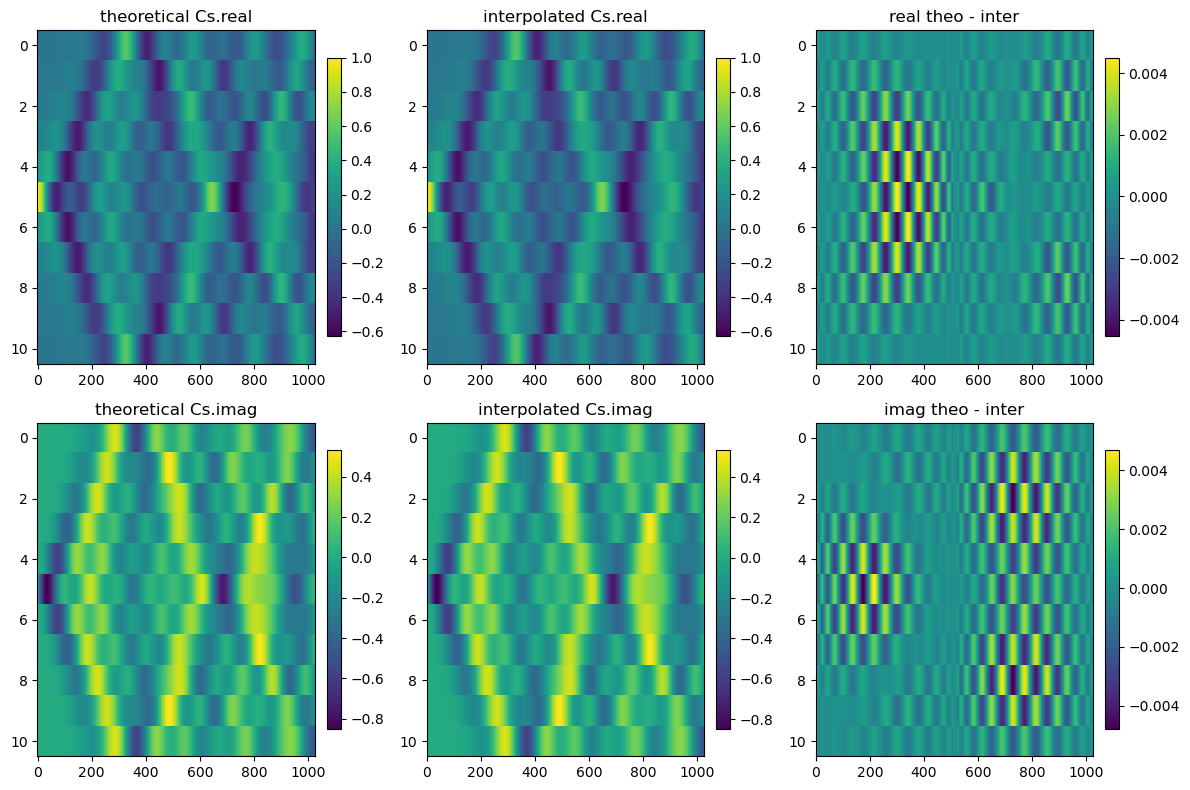

In [19]:
rows, cols = 2, 3  # Define grid dimensions
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

# Data and titles for each subplot
data = [
    (Cs.real, 'theoretical Cs.real'),
    (np.real(interp_Cs), 'interpolated Cs.real'),
    (Cs.real - np.real(interp_Cs), 'real theo - inter'),
    (Cs.imag, 'theoretical Cs.imag'),
    (np.imag(interp_Cs), 'interpolated Cs.imag'),
    (Cs.imag - np.imag(interp_Cs), 'imag theo - inter')
]

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 8))

# Loop through data and subplots
for ax, (image, title) in zip(axs.flat, data):
    im = ax.imshow(image, aspect='auto', interpolation='none')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Add colorbar
    ax.set_title(title)

plt.tight_layout()
plt.show()

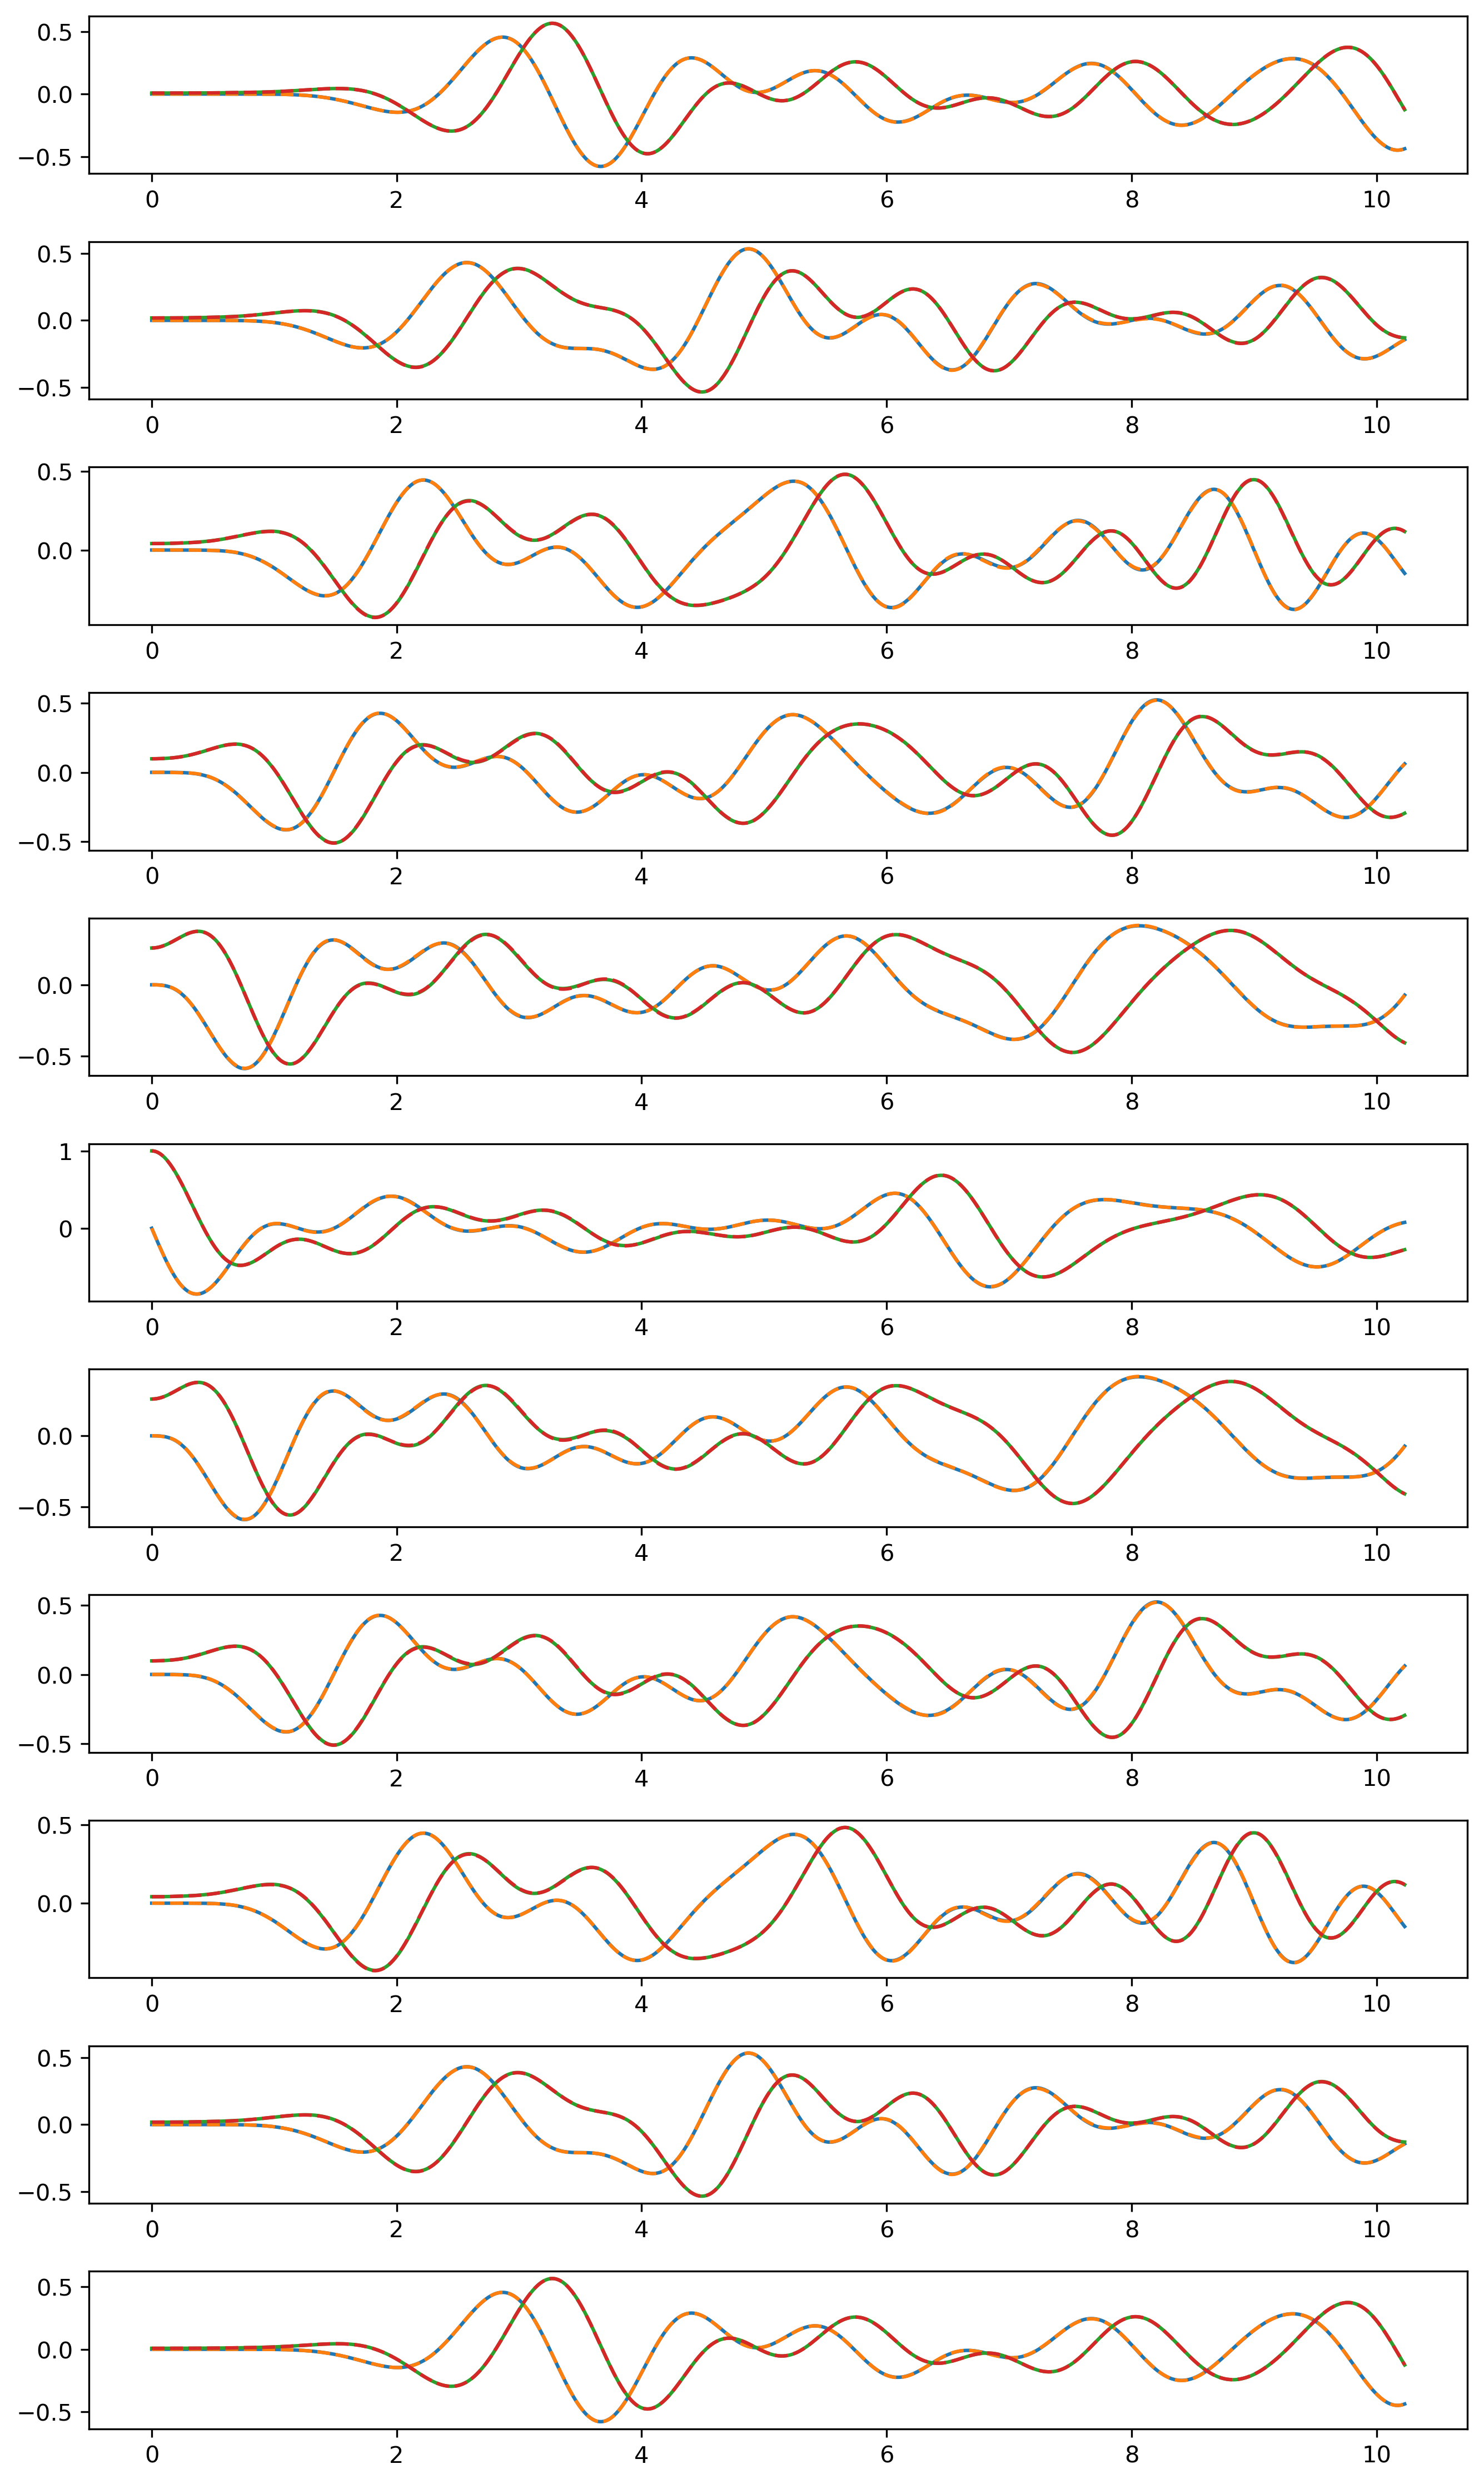

In [20]:
fig, axs = plt.subplots(nrows=D, figsize=(9,15), dpi=300)

D_list = np.arange(D)

for i,item in enumerate(D_list):
    axs[i].plot(ts, np.imag(func_vals[:,item]), '-')
    axs[i].plot(ts, np.imag(func_interp[:,item]), '--')
    axs[i].plot(ts, np.real(func_vals[:,item]), '-')
    axs[i].plot(ts, np.real(func_interp[:,item]), '--')
    #axs[i].set_xlim(0,0.2)

fig.tight_layout()

plt.show()

### Error vs evals for Chebyshev

In [21]:
#here we could define a dictionary to make things more compact
err_max = []
err_2 = []
evals = []
func_interp_list = []

chi_list = [i for i in range(2,10)]
chi_list.extend([i for i in range(10,40,5)])
chi_list.append(70)

for chi in chi_list:
# get MPS from Chebyshev interpolation
    _, eval, errmax, err2, func_interp = Cbs.Chebyshev_interpolation_Dsite(Cs_chebyshev_Dsites, # function to be interpolated
                                 func_vals,
                                 L=n,              # number of MPS tensors
                                 D = D,
                                 chi=chi)           # (half of the) bond dimension

    err_max.append(errmax)
    err_2.append(err2)
    evals.append(eval)
    func_interp_list.append(func_interp)




2 2


2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 15
2 20
2 25
2 30
2 35
2 70


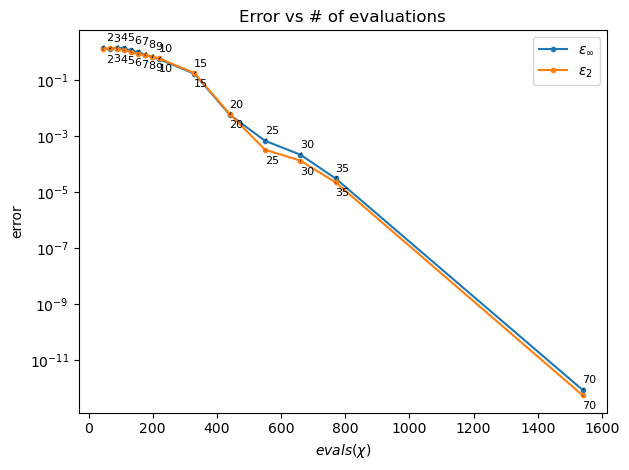

In [22]:
plt.plot(np.array(evals), np.array(err_max), ".-", label = r"$\epsilon_\infty$")
plt.plot(np.array(evals), np.array(err_2), ".-", label = r"$\epsilon_2$")

# Annotate the points with their chi values
for i, chi in enumerate(chi_list):
    # Annotate error_max (first curve)
    plt.annotate(f"{chi}", (evals[i], err_max[i]),
                 textcoords="offset points", xytext=(5, 5), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')

    # Annotate error_2 (second curve)
    plt.annotate(f"{chi}", (evals[i], err_2[i]),
                 textcoords="offset points", xytext=(5, -10), fontsize=8,
                 arrowprops=dict(arrowstyle="-", lw=0.5),
                 ha='center')
    

plt.yscale("log")
plt.xlabel(r"$evals(\chi)$")
plt.ylabel(r"error")
plt.legend()
plt.title("Error vs # of evaluations")
plt.tight_layout()
plt.show()

In [47]:
# Fourier transform the time-domain with windowing function cos(pi/2 * t/T)**nw
def FT_different(Ct, t_list, x_list, nw=4):
    """
    full complex data as input. 
    data only for positive time.
    """
    #Ct will now be matrix X x T
    
    n = len(t_list)
    Wfunlist = [np.cos(np.pi*t_list[t]/(2*t_list[-1]))**nw  for t in range(n)]
    a,b = Ct.shape 
    input_list = np.zeros((a,b), dtype = np.complex128)
    FTresult_t = np.zeros((a,b), dtype = np.complex128)
    FTresult = np.zeros((a,b), dtype = np.complex128)

    for i in range(a):
        input_list[i,:] = Wfunlist[:] * (np.array(Ct[i,:]))
        FTresult_t[i,:] = np.fft.fft(input_list[i,:])
    
    for j in range(b):
        FTresult[:,j] = np.fft.fft(FTresult_t[:,j])
    

    # freq_w = 2 * np.pi * np.fft.fftfreq(n, t_list[1]-t_list[0])
    # freq_w = np.fft.fftshift(freq_w)
    # freq_k = 2 * np.pi * np.fft.fftfreq(n, x_list[1]-x_list[0])
    # freq_k = np.fft.fftshift(freq_k)
#     for i in range(a):
#         FTresult[i,:] = np.fft.fftshift(FTresult[i,:])
#     for j in range(b):
#         FTresult[:,j] = np.fft.fftshift(FTresult[:,j])
    
    return FTresult

(11, 1024)
(11, 1024)


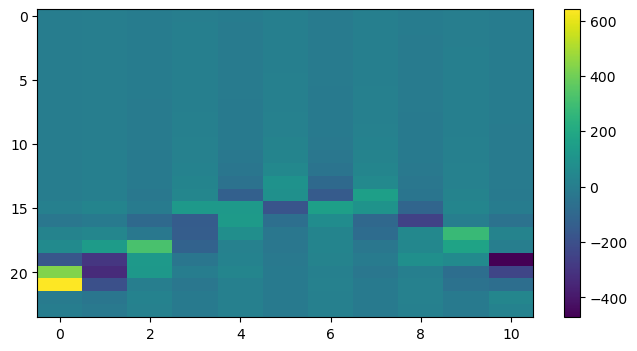

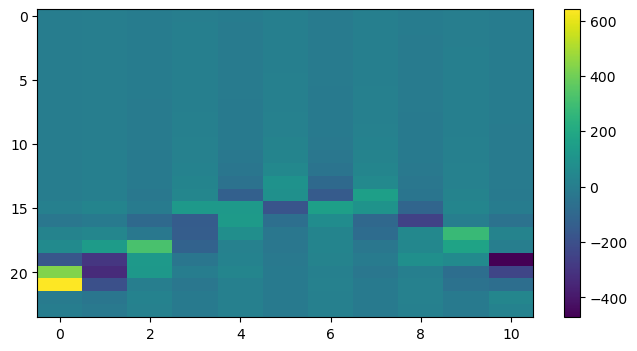

In [51]:
D = 11
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

FTresult_different = FT_different(Ct=Cs, t_list=np.arange(N)*dt, x_list = np.arange(D), nw=3)
FTresult_different_i = FT_different(Ct=interp_Cs, t_list=np.arange(N)*dt, x_list = np.arange(D), nw=3)

print(FTresult_different.shape)
print(FTresult_different_i.shape)

plt.figure(figsize=(8, 4))
plt.imshow(np.real(FTresult_different[:,1000:].T), aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()

plt.figure(figsize=(8, 4))
plt.imshow(np.real(FTresult_different_i[:,1000:].T), aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()

In [49]:
# Fourier transform the time-domain with windowing function cos(pi/2 * t/T)**nw
import scipy.fft as fft

def FT(Ct, t_list, x_list, nw=4):
    """
    full complex data as input. 
    data only for positive time.
    """
    #Ct will now be matrix X x T
    
    n = len(t_list)
    Wfunlist = [np.cos(np.pi*t_list[t]/(2*t_list[-1]))**nw  for t in range(n)]
    a,b = Ct.shape 
    input_list = np.zeros((a,b), dtype = np.complex128)
    FTresult = np.zeros((a,b), dtype = np.complex128)

    for i in range(a):
        input_list[i,:] = Wfunlist[:] * (np.array(Ct[i,:]))
    
    FTresult = fft.fft2(input_list)
    
    return FTresult

(11, 1024)
(11, 1024)


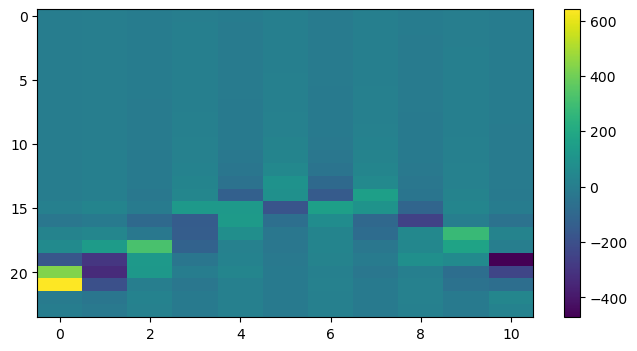

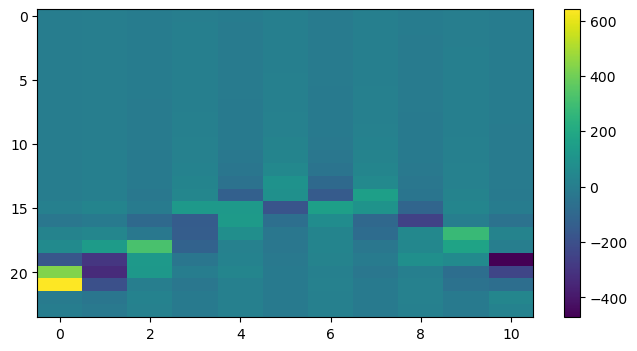

In [50]:
D = 11
a, b = Cs.shape
interp_Cs = func_interp.T.reshape(a, b)

FTresult = FT(Ct=Cs, t_list=np.arange(N)*dt, x_list = np.arange(D), nw=3)
FTresult_i = FT(Ct=interp_Cs, t_list=np.arange(N)*dt, x_list = np.arange(D), nw=3)

print(FTresult.shape)
print(FTresult_i.shape)

plt.figure(figsize=(8, 4))
plt.imshow(np.real(FTresult[:,1000:].T), aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()

plt.figure(figsize=(8, 4))
plt.imshow(np.real(FTresult_i[:,1000:].T), aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()